# FairSVM

[![Slides](https://img.shields.io/badge/🦌-ReHLine-blueviolet)](https://rehline-python.readthedocs.io/en/latest/)

The FairSVM solves the following optimization problem:

$$
\begin{align}
  & \min_{\mathbf{\beta} \in \mathbb{R}^d} \frac{C}{n} \sum_{i=1}^n ( 1 - y_i \mathbf{\beta}^\intercal \mathbf{x}_i )_+ + \frac{1}{2} \| \mathbf{\beta} \|_2^2, \nonumber \\
  \text{subject to } & \quad \frac{1}{n} \sum_{i=1}^n \mathbf{z}_i \mathbf{\beta}^\intercal \mathbf{x}_i \leq \mathbf{\rho}, \quad \frac{1}{n} \sum_{i=1}^n \mathbf{z}_i \mathbf{\beta}^\intercal \mathbf{x}_i \geq -\mathbf{\rho},
\end{align}
$$

where:

* $\mathbf{x}_i \in \mathbb{R}^d$ is a feature vector
* $y_i \in \{-1, 1\}$ is a binary label
* $\mathbf{z}_i$ is a collection of **centered sensitive features**, such as gender and/or race, satisfying:

$$\sum_{i=1}^n z_{ij} = 0,$$

* $\mathbf{z}_i \in \mathbb{R}^{d_0}$ is a $d_0$-length sensitive feature vector
* $\mathbf{\rho} \in \mathbb{R}_+^{d_0}$ is a vector of constants that trade-off predictive accuracy and fairness

The constraints limit the correlation between the sensitive features and the decision function, ensuring fairness in the predictions.

> **Note.** Since the hinge loss is a plq function, and fairness constraints are linear, thus we can solve it by `rehline.plqERM_Ridge`.

In [1]:
## simulate data
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()

n, d = 10000, 5
X, y = make_classification(n_samples=n, n_features=d, n_redundant=0)
## convert y to +1/-1
y = 2*y - 1
X = scaler.fit_transform(X)

## we take the first column of X as sensetive features, and tol is 0.1
sen_idx = [0]
tol_sen = 0.1

## SVM as baseline

In [2]:
## we first run a SVM
from rehline import plqERM_Ridge

clf = plqERM_Ridge(loss={'name': 'svm'}, C=1.0, max_iter=50000)
clf.fit(X=X, y=y)

## FairSVM

In [3]:
## solve FairSVM via `plqERM_Ridge` by adding `constraint`
from rehline import plqERM_Ridge

fclf = plqERM_Ridge(loss={'name': 'svm'},
                   constraint=[{'name': 'fair',
                                'sen_idx': sen_idx,
                                'tol_sen': tol_sen}],
                   C=1.0,
                   max_iter=50000)
fclf.fit(X=X, y=y)

## Results

In [4]:
import pandas as pd
## score
score = clf.decision_function(X)
fscore = fclf.decision_function(X)

svm_perf = len(y[score*y > 0])/n
fsvm_perf = len(y[fscore*y > 0])/n

svm_corr = score.dot(X_sen) / n
fsvm_corr = fscore.dot(X_sen) / n

# Create a pandas DataFrame to store the results
results = pd.DataFrame({
    'Model': ['SVM', 'FairSVM'],
    'Train Performance': [svm_perf, fsvm_perf],
    'Correlation with Sensitive Features': [svm_corr, fsvm_corr]
})

# Print the results as a table
print(results.to_string(index=False))

  Model  Train Performance  Correlation with Sensitive Features
    SVM             0.8853                             2.535203
FairSVM             0.5856                             0.100212


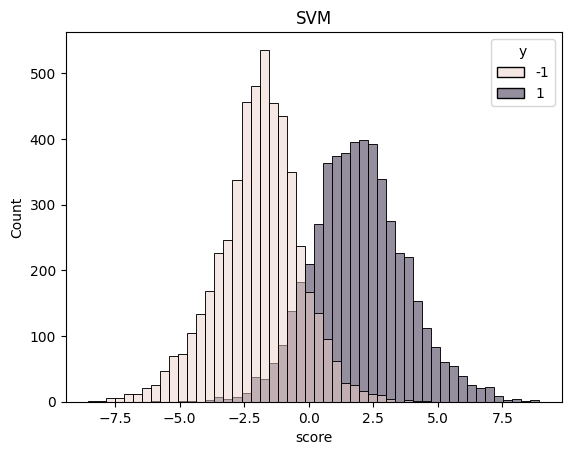

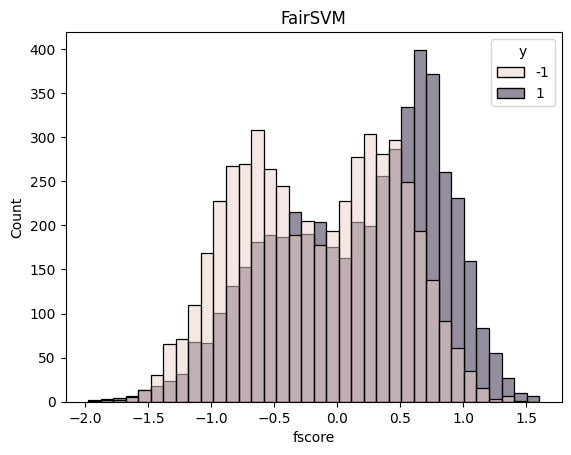

In [5]:
import seaborn as sns
import pandas as pd
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

df = pd.DataFrame({'score': score, 'fscore': fscore, 'y': y})

sns.histplot(df, x="score", hue="y").set_title("SVM")
plt.show()
sns.histplot(df, x="fscore", hue="y").set_title("FairSVM")
plt.show()